In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Define the actual distribution parameters

In [4]:
n_dim = 3
mu_true = np.zeros(n_dim)
beta_true = np.diag([0.2,0.3,0.4])
print beta_true

[[0.2 0.  0. ]
 [0.  0.3 0. ]
 [0.  0.  0.4]]


In [5]:
def unnormalized_func(tetha,params):
    mu = params[0]
    beta = params[1]
    return np.exp(-0.5*np.dot((tetha-mu).T, np.dot(beta,tetha-mu)))

In [9]:
def unnormalized_multimodal(tetha,params):
    pis = params[0]
    mus = params[1]
    bethas = params[2]
    prob = 0
    for i,pi in enumerate(pis):
        prob += pi*np.exp(-0.5*np.dot((tetha-mus[i]).T, np.dot(bethas[i],tetha-mus[i])))
    return prob 

In [13]:
def MH_sampling(func, params,tetha0, n = 1000, lamda= 1):
    samples = [tetha0]
    cur_tetha = tetha0.copy()
    n_dim = len(tetha0)
    accept_num = 0
    for i in range(n):
        #print cur_tetha
        cur_func_value = func(cur_tetha,params)
        #Proposal distribution
        #new_tetha = cur_tetha + (np.random.rand(n_dim)-0.5)*lamda
        new_tetha = cur_tetha + (np.random.multivariate_normal(np.zeros(n_dim), np.eye(n_dim)))*lamda
        
        new_func_value = func(new_tetha,params)
        #decide whether to accept or reject
        accept_threshold = new_func_value/cur_func_value
        random_num = np.random.rand()
        #if accept_threshold > 1 or random_num < accept_threshold:
        if random_num < accept_threshold: #equivalent to the above
            samples.append(new_tetha)
            cur_tetha = new_tetha
            accept_num += 1
        else:
            samples.append(cur_tetha)
    
    return np.array(samples), 1.0*accept_num/n

In [128]:
tetha0 = np.array([20,-40,30])
samples, acceptance_rate = MH_sampling(unnormalized_func, [mu_true,beta_true], tetha0, n = 5000,lamda = 1.5)
print 'Acceptance rate: ' + str(acceptance_rate)

Acceptance rate: 0.5254


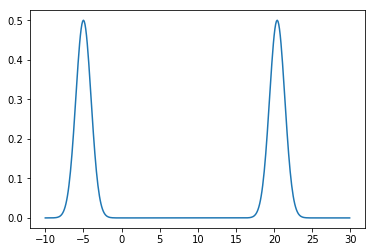

In [35]:
#check the unnormalized multimodal
x = np.arange(-10,30,0.1)
y = []
pis = [0.5,0.5]
mus = [np.array([-5.]), np.array([20.4])]
bethas = [np.array([1.]), np.array([1.])]

for x_i in x:
    y.append(unnormalized_multimodal(x_i, [pis,mus,bethas]))
    
plt.plot(x,y)

In [41]:
tetha0 = np.array([-20.])
samples, acceptance_rate = MH_sampling(unnormalized_multimodal, [pis,mus,bethas], tetha0, n = 1000,lamda = 1.5)
print 'Acceptance rate: ' + str(acceptance_rate)

Acceptance rate: 0.547


In [45]:
def calc_autocorrelation(samples,d=1):
    mu = np.mean(samples)
    nom = 0.
    n = len(samples)
    denom = np.var(samples)*n
    for i in range(n-d):
        nom += (samples[i]-mu)*(samples[i+d]-mu)
    return nom/denom

In [46]:
def statistics_1(samples):
    #calculate the sum for each of the sample
    new_samples = [np.sum(sample) for sample in samples]
    return new_samples

def statistics_2(samples):
    #x*x
    new_samples = [np.dot(sample, sample) for sample in samples]
    return new_samples

def statistics_4(samples):
    #x_0**2
    new_samples = [sample[0]**2 for sample in samples]
    return new_samples

def statistics_5(samples, i=0,j=1):
    #x_i*x_j
    new_samples = [sample[i]*sample[j] for sample in samples]
    return new_samples

def statistics_6(samples, i=0,j=1):
    #deviation from mu
    mu = np.mean(samples)
    new_samples = [np.linalg.norm(sample-mu) for sample in samples]
    return new_samples


In [47]:
sample_statistic1 = statistics_1(samples)
sample_statistic2 = statistics_2(samples)
sample_statistic4 = statistics_4(samples)
#sample_statistic5 = statistics_5(samples, 1, 2)
#sample_statistic6 = statistics_6(samples)

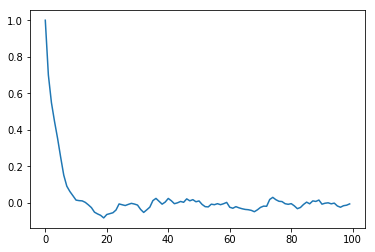

In [48]:
autocorrs = []
for d in range(0,500, 5):
    autocorrs.append(calc_autocorrelation(sample_statistic1,d))
plt.plot(autocorrs)

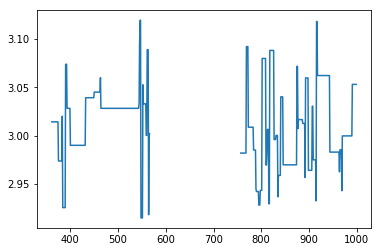

In [40]:
plt.plot(np.log(sample_statistic1[:1000]))

### Part 2 

In [260]:
from scipy.special import loggamma

def unnormalized_t(tetha, params):
    df, mu, sigma  = params[0], params[1], params[2]
    return (1+ ((tetha-mu)**2)/(df*(sigma**2)))**(-0.5*(df+1))

def stable_exp(x_array):
    return np.exp( x_array - x_array.max() )

def unnormalized_post(tetha, params): #note: tetha and params here differ from the above
    df, mu,sigma = tetha[0], tetha[1], tetha[2]
    x  = params[0]
    n = len(x)
    cond = np.sum([np.log(unnormalized_t(x_i, [df,mu,sigma])) for x_i in x])
    cond += n*loggamma((df+1)/2.)-n*loggamma(df/2.)
    cond += -n*np.log(sigma)
    cond += -n*0.5*np.log(df*np.pi)
    prior = np.log(1./sigma)
    return cond + prior

In [497]:
from scipy.stats import t
import scipy as scp
mu_true = 0.3
sigma_true = 1.
df_true = 4.2
x = t.rvs(df=df_true,loc = mu_true, scale=sigma_true,size=1000)

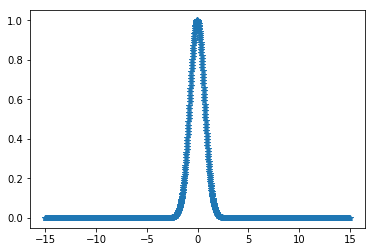

In [560]:
sigma_true = 10
df_true = 10000
mu = np.arange(-15,15,0.02)
post_mu = np.array([unnormalized_post([df_true,mu_i,sigma_true], [x]) for mu_i in mu])
plt.plot(mu,stable_exp(post_mu), '*')

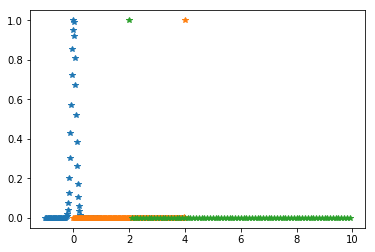

In [548]:
sigma = np.arange(0.01,4,0.02)
post_sigma = np.array([unnormalized_post([df_true,mu_true,sigma_i], [x]) for sigma_i in sigma])
plt.plot(sigma,stable_exp(post_sigma), '*')

df = np.arange(2,10,.1)
post_df = np.array([unnormalized_post([df_i,mu_true,sigma_true], [x]) for df_i in df])
plt.plot(df,stable_exp(post_df), '*')

In [517]:
def MH_Gibbs_sampling(func, params,tetha0, n = 1000, lamda= 1):
    samples = [tetha0]
    cur_tetha = tetha0.copy()
    n_dim = len(tetha0)
    accept_num = 0
    for i in range(n):
        #print cur_tetha
        cur_func_value = func(cur_tetha,params)
        
        #iterate through each tetha
        for j in range(len(tetha0)):
            #Proposal distribution
            selector = np.zeros(len(tetha0))
            selector[j] = 1.
            if j == 0:
                new_tetha = cur_tetha + (np.random.rand(n_dim)-0.5)*lamda*10.*selector
            else:
                new_tetha = cur_tetha + (np.random.rand(n_dim)-0.5)*lamda*selector
            
            #new_tetha = cur_tetha + (np.random.multivariate_normal(np.zeros(n_dim), np.eye(n_dim)))*lamda
            #print cur_tetha, new_tetha
            new_func_value = func(new_tetha,params)
            #decide whether to accept or reject
            accept_threshold = np.exp(new_func_value-cur_func_value)
            random_num = np.random.rand()
            if accept_threshold > 1 or random_num < accept_threshold:
                samples.append(new_tetha)
                cur_tetha = new_tetha
                accept_num += 1
            else:
                samples.append(cur_tetha)

    return np.array(samples), 1.0*accept_num/(n*3)

In [538]:
tetha0 = np.array([100,20,2])

In [539]:
samples,success_rate = MH_Gibbs_sampling(unnormalized_post, [x], tetha0, lamda=0.5,n=1000)

In [540]:
success_rate

0.84

In [541]:
np.mean(samples,axis=0)

array([41.29964169,  4.35192069,  9.8399478 ])

In [542]:
np.std(samples,axis=0)

array([18.83689012,  5.71698627,  2.11417958])

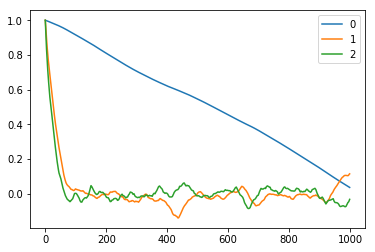

In [528]:
for i in range(samples.shape[1]):
    autocorrs = []
    for d in range(0,1000, 1):
        autocorrs.append(calc_autocorrelation(samples[:,i],d))
    plt.plot(autocorrs,label=i)
plt.legend()

In [ ]:
import seaborn as sb

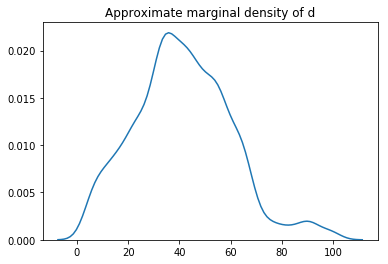

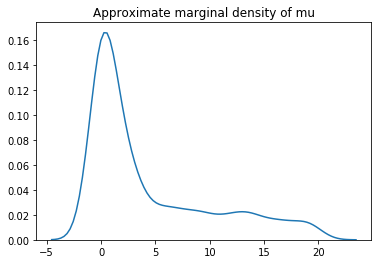

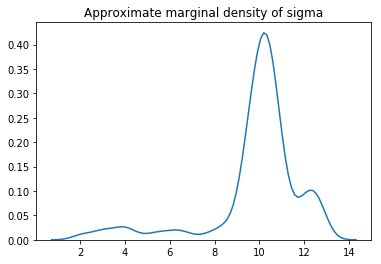

In [543]:
plt.figure()
sb.kdeplot(samples[:,0])
plt.title("Approximate marginal density of d")

plt.figure()
sb.kdeplot(samples[:,1])
plt.title("Approximate marginal density of mu")

plt.figure()
sb.kdeplot(samples[:,2])
plt.title("Approximate marginal density of sigma")

plt.show()

In [544]:
print df_true, mu_true, sigma_true

4.2 0.3 1.0


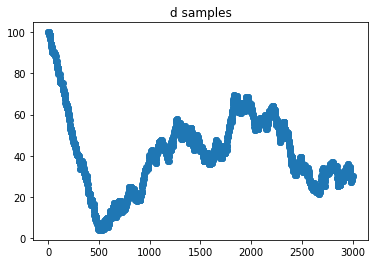

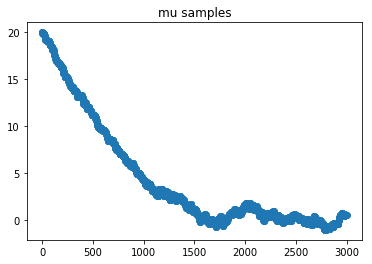

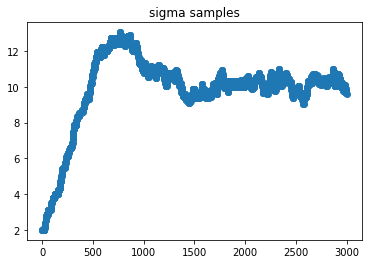

In [545]:
plt.figure()
plt.plot(samples[:,0], 'o')
plt.title("d samples")

plt.figure()
plt.plot(samples[:,1], 'o')
plt.title("mu samples")

plt.figure()
plt.plot(samples[:,2], 'o')
plt.title("sigma samples")
plt.show()